### Analyze the TKE budget

In [3]:
# interactive figure
%matplotlib widget
# %matplotlib inline

In [1]:
# auto reload modules
%load_ext autoreload
%autoreload 2

import warnings
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.ticker as tkr
import matplotlib.gridspec as gridspec
from sys import platform
from xgcm import Grid
from dask.distributed import LocalCluster, Client
from IPython.display import HTML, display
from matplotlib.colors import LinearSegmentedColormap, CenteredNorm, BoundaryNorm
from viztool import FormatScalarFormatter

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

def fxn():
    warnings.warn('deprecated', DeprecationWarning)

In [2]:
if platform == 'linux' or platform == 'linux2':
    data_dir = '/glade/derecho/scratch/zhihuaz/FrontalZone/Output/'
elif platform == 'darwin':
    data_dir = '/Users/zhihua/Documents/Work/Research/Projects/TRACE-SEAS/FrontalZone/Data/'
else:
    print('OS not supported.')

### Budgets for homogeneous turbulent boundary layers

#### KE budget using resolved velocities

In [18]:
# case = 'wind_center2'
case = 'wind_weno5'
# ds = xr.open_dataset('/glade/u/home/zhihuaz/Projects/TRACE-SEAS/FrontalZone/mwe_KE_budget.nc')
ds = xr.open_dataset('/glade/u/home/zhihuaz/Projects/TRACE-SEAS/Test/mwe_KE_budget_'+case+'.nc')
ds.close()
ds['timeTf'] = ds.time/np.timedelta64(int(np.around(2*np.pi/1e-4)), 's')
ds

<xarray.Dataset> Size: 18MB
Dimensions:       (zC: 64, zF: 65, xC: 32, yF: 32, xF: 32, yC: 32, time: 4321)
Coordinates:
  * zC            (zC) float64 512B -48.76 -46.38 -44.21 ... -0.7818 -0.2606
  * zF            (zF) float64 520B -50.0 -47.51 -45.25 ... -1.042 -0.5212 0.0
  * xC            (xC) float64 256B 1.562 4.688 7.812 ... 92.19 95.31 98.44
  * yF            (yF) float64 256B 0.0 3.125 6.25 9.375 ... 90.62 93.75 96.88
  * xF            (xF) float64 256B 0.0 3.125 6.25 9.375 ... 90.62 93.75 96.88
  * yC            (yC) float64 256B 1.562 4.688 7.812 ... 92.19 95.31 98.44
  * time          (time) timedelta64[ns] 35kB 00:00:00 ... 3 days 00:00:00
Data variables:
    KE_stress     (time, zC) float64 2MB ...
    KE_tendency   (time, zC) float64 2MB ...
    KE_adv        (time, zC) float64 2MB ...
    KE_advection  (time, zC) float64 2MB ...
    KE            (time, zC) float64 2MB ...
    KE_pressure   (time, zC) float64 2MB ...
    KE_buoyancy   (time, zC) float64 2MB ...
    uh            (time, zC) float64 2MB ...
    timeTf        (time) float64 35kB 0.0 0.0009549 0.00191 ... 4.124 4.125
Attributes:
    interval:              60.0
    Oceananigans:          This file was generated using Oceananigans v0.90.14
    Julia:                 This file was generated using Julia Version 1.10.2...
    output time interval:  Output was saved every 1 minute.
    date:                  This file was generated on 2024-05-10T09:01:22.565.
    schedule:              TimeInterval

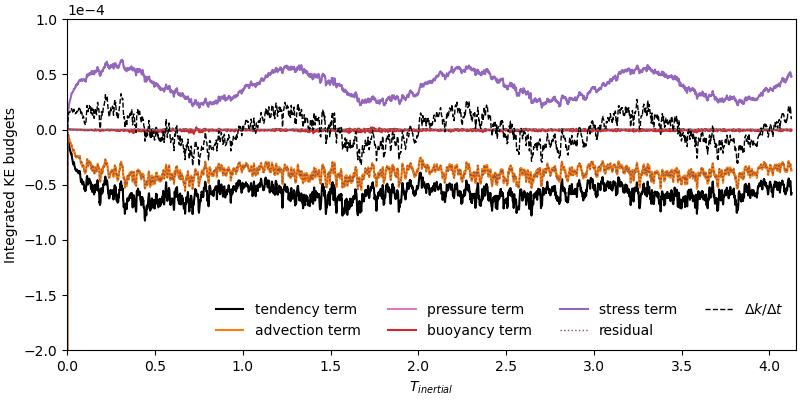

In [16]:
plt.close()
plt.figure(figsize=(8,4), constrained_layout=True)

# plt.plot(ds.timeTf, ds.iKE_tendency, 'k');
# plt.plot(ds.timeTf, ds.iKE_advection, 'C1');
# plt.plot(ds.timeTf, ds.iKE_pressure, 'C2');
# plt.plot(ds.timeTf, ds.iKE_buoyancy, 'C3');
# plt.plot(ds.timeTf, ds.iKE_stress, 'C4');
# plt.plot(ds.timeTf, (ds.iKE_tendency + ds.iKE_advection + ds.iKE_pressure - ds.iKE_buoyancy + ds.iKE_stress), ':C5', lw=1)

deltaz = np.diff(ds.zF)
ds['KE_stress_top'] = (ds.uh.where(ds.zC==ds.zC[-1])*(-2e-4)/deltaz[-1]).fillna(0)
ds['KE_stress_all'] =  ds.KE_stress + ds.KE_stress_top

itop = None
ds['IKE'] = (ds.KE*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_tendency'] = (ds.KE_tendency*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_advection'] = (ds.KE_advection*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_adv'] = (ds.KE_adv*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_pressure'] = (ds.KE_pressure*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_buoyancy'] = (ds.KE_buoyancy*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_stress_all'] = (ds.KE_stress_all*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_stress'] = (ds.KE_stress*deltaz).isel(zC=slice(None,itop)).sum('zC')

ds['dIKE_dt'] = ds.IKE.differentiate('time', datetime_unit='s')
ds['IKE_residual'] = ds.dIKE_dt + ds.IKE_adv + ds.IKE_pressure - ds.IKE_buoyancy + ds.IKE_stress_all

plt.plot(ds.timeTf,  ds.IKE_tendency, 'k');
plt.plot(ds.timeTf, -ds.IKE_advection, 'C1');
plt.plot(ds.timeTf, -ds.IKE_pressure, 'C6');
plt.plot(ds.timeTf,  ds.IKE_buoyancy, 'C3');
plt.plot(ds.timeTf, -ds.IKE_stress_all, 'C4')
plt.plot(ds.timeTf,  ds.IKE_residual, ':C5', lw=1)
plt.plot(ds.timeTf,  ds.dIKE_dt, '--k', lw=1)
plt.legend(['tendency term', 'advection term', 'pressure term', 'buoyancy term',
            'stress term', 'residual', r'$\Delta k/\Delta t$'],
           frameon=False, loc='lower right', ncol=4)
plt.plot(ds.timeTf, -ds.IKE_adv, ':c', lw=1)
plt.xlabel(r'$T_{inertial}$')
plt.ylabel('Integrated KE budgets')
# plt.ylim(-11e-5, 11e-5)
# plt.ylim(-4.2e-5, 4e-5)
plt.ticklabel_format(axis='y', scilimits=(0,0))
plt.xlim(0,4.15)
plt.ylim(-2e-4, 1e-4);

# ax1 = plt.gca().twinx()
# color = 'C0'
# ax1.set_ylabel(r'$\int KE \: dV$', color=color)
# ax1.plot(ds.timeTf, ds.IKE, color=color)
# # ax1.set_yticks(np.array([0, 1, 2, 3, 4])*1e-1)
# ax1.tick_params(axis='y', labelcolor=color)
# # ax1.set_ylim(-0.4, 0.4);
# # ax1.set_ylim(-0.42, 0.4);

# plt.savefig('../Figures/mwe_iKE_budgets_'+case, dpi=250)

In [ ]:
plt.close()
plt.figure(figsize=(7.3,5), constrained_layout=True)

plt.subplot(121)
time_interval = (ds.timeTf >= 3) & (ds.timeTf < 3.5)
ke = ds.KE.where(time_interval, drop=True).isel(time=[0,-1]).T
dkedt = ke.diff('time')/ke.time.diff('time').dt.seconds
plt.plot(ds.KE_tendency.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'k')
plt.plot(dkedt, ds.zC, '--k')
plt.plot(-ds.KE_adv.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C1')
plt.plot(-ds.KE_pressure.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C2')
plt.plot(ds.KE_buoyancy.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C3')
plt.plot(-ds.KE_stress_all.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C4')
plt.plot((ds.KE_tendency + ds.KE_adv + ds.KE_pressure - ds.KE_buoyancy +
         ds.KE_stress_all).where(time_interval).mean('time')[:itop], ds.zC[:itop], ':C5', lw=1)
plt.plot(-ds.KE_advection.where(time_interval).mean('time')[:itop], ds.zC[:itop], ':b', lw=1)
plt.text(0.02,0.42, r'$T_{inertial} \in [3,3.5)$', fontsize=12, transform=plt.gca().transAxes)
plt.grid('on', ls='--', lw=0.4)
plt.xlim(-3e-6, 3e-6)
plt.ylim(-40,0)
plt.xlabel('Time averaged KE budget term');

ax1 = plt.gca().twiny()
color = 'C0'
ax1.set_xlabel(r'$k$', color=color)
ax1.plot(ds.KE.where(time_interval).mean('time'), ds.zC, color=color)
ax1.set_xticks(np.array([0, 0.5, 1, 1.5])*1e-2)
ax1.tick_params(axis='x', labelcolor=color)
plt.ticklabel_format(axis='x', scilimits=(0,0))
ax1.set_xlim(-0.019, 0.019)

plt.subplot(122)
time_interval = (ds.timeTf >= 3.5) & (ds.timeTf < 4)
ke = ds.KE.where(time_interval, drop=True).isel(time=[0,-1]).T
dkedt = ke.diff('time')/ke.time.diff('time').dt.seconds
plt.plot(ds.KE_tendency.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'k')
plt.plot(dkedt, ds.zC, '--k')
plt.plot(-ds.KE_adv.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C1')
plt.plot(-ds.KE_pressure.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C2')
plt.plot(ds.KE_buoyancy.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C3')
plt.plot(-ds.KE_stress_all.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C4')
plt.plot((ds.KE_tendency + ds.KE_adv + ds.KE_pressure - ds.KE_buoyancy +
         ds.KE_stress_all).where(time_interval).mean('time')[:itop], ds.zC[:itop], ':C5', lw=1)
plt.legend(['tendency term', r'$\Delta k/\Delta t$', 'advection term', 'pressure term', 'buoyancy term',
            'stress term', 'residual'], frameon=False, loc='lower left', borderpad=0.1)
plt.plot(-ds.KE_advection.where(time_interval).mean('time')[:itop], ds.zC[:itop], ':b', lw=1)
plt.text(0.02,0.42, r'$T_{inertial} \in [3.5,4)$', fontsize=12, transform=plt.gca().transAxes)
plt.gca().set_yticklabels([])
plt.grid('on', ls='--', lw=0.4)
plt.xlim(-3e-6, 3e-6)
plt.ylim(-40,0)
plt.xlabel('Time averaged KE budget term');

ax2 = plt.gca().twiny()
color = 'C0'
ax2.set_xlabel(r'$k$', color=color)
ax2.plot(ds.KE.where(time_interval).mean('time'), ds.zC, color=color)
ax2.set_xticks(np.array([0, 0.5, 1, 1.5])*1e-2)
ax2.tick_params(axis='x', labelcolor=color)
plt.ticklabel_format(axis='x', scilimits=(0,0))
ax2.set_xlim(-0.019, 0.019);

# plt.savefig('../Figures/mwe_KE_budgets_'+case, dpi=250)

#### TKE budget using perturbations from horizontal averages

In [ ]:
case = 'wind_center2'
# case = 'wind_weno5'
# case = 'buoyancy_center2'
# ds = xr.open_dataset('/glade/u/home/zhihuaz/Projects/TRACE-SEAS/FrontalZone/mwe_TKE_budget.nc')
ds = xr.open_dataset('/glade/u/home/zhihuaz/Projects/TRACE-SEAS/FrontalZone/mwe_TKE_budget_'+case+'.nc')
ds.close()
ds['timeTf'] = ds.time/np.timedelta64(int(np.around(2*np.pi/1e-4)), 's')
ds

In [ ]:
plt.close()
plt.figure(figsize=(8,4), constrained_layout=True)
time_interval = (ds.timeTf >= 0) & (ds.timeTf < 5.8)

deltaz = np.diff(ds.zF)
itop = None
ds['ITKE'] = (ds.TKE*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['ITKE_VBP'] = (ds.TKE_VBP*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['ITKE_ASP'] = (ds.TKE_ASP*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['ITKE_Tprs'] = (ds.TKE_Tprs*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['ITKE_Tsgs'] = (ds.TKE_Tsgs*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['ITKE_Ttur'] = (ds.TKE_Ttur*deltaz).isel(zC=slice(None,itop)).sum('zC')
# ds['ITKE_eps'] = (ds.TKE_eps*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['ITKE_dissipation'] = (ds.TKE_dissipation*deltaz).isel(zC=slice(None,itop)).sum('zC')
# ds['ITKE_diss0'] = (ds.TKE_diss0*deltaz).isel(zC=slice(None,itop)).sum('zC')

ds['dITKE_dt'] = ds.ITKE.differentiate('time', datetime_unit='s')
# ds['ITKE_residual'] = ds.dITKE_dt - ds.dITKE_VBP 

# plt.plot(ds.timeTf.where(time_interval), 3e-5*ds.uh.isel(zC=-1).where(time_interval));
plt.plot(ds.timeTf.where(time_interval),  ds.ITKE_VBP.where(time_interval));
plt.plot(ds.timeTf.where(time_interval),  ds.ITKE_ASP.where(time_interval));
plt.plot(ds.timeTf.where(time_interval), -ds.ITKE_Tprs.where(time_interval));
plt.plot(ds.timeTf.where(time_interval), -ds.ITKE_Tsgs.where(time_interval));
plt.plot(ds.timeTf.where(time_interval), -ds.ITKE_Ttur.where(time_interval));
# plt.plot(ds.timeTf.where(time_interval), -ds.ITKE_eps.where(time_interval), 'k')
plt.plot(ds.timeTf.where(time_interval), -ds.ITKE_dissipation.where(time_interval), 'gray')
plt.plot(ds.timeTf.where(time_interval),  ds.dITKE_dt.where(time_interval), '--k')
plt.plot(ds.timeTf.where(time_interval), (ds.dITKE_dt - (ds.ITKE_VBP + ds.ITKE_ASP - ds.ITKE_Tprs - ds.ITKE_Tsgs - ds.ITKE_Ttur -
                                          ds.ITKE_dissipation)).where(time_interval), ':', lw=1)
plt.legend(['VBP', 'ASP', 'Pressure Trans.', 'SGS Trans.', 'Turbulent Trans.',
            'Dissipation', r'$\Delta e/\Delta t$', 'Residual'],
           frameon=False, ncol=4)
plt.xlabel(r'$T_{inertial}$')
plt.ylabel('Integrated TKE budgets')
plt.ylim(-4e-5, 3.3e-5)
# plt.ylim(-6e-6, 6e-6)
plt.ticklabel_format(axis='y', scilimits=(0,0))
plt.xlim(0,4.15)

ax1 = plt.gca().twinx()
color = 'xkcd:amber'
ax1.set_ylabel(r'$\int TKE \: dV$', color=color)
ax1.plot(ds.timeTf.where(time_interval), ds.ITKE.where(time_interval), color=color)
ax1.set_yticks(np.array([0, 1, 2, 3, 4])*1e-2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-0.04, 0.033);
# ax1.set_ylim(-0.033, 0.033);

# plt.savefig('../Figures/mwe_iTKE_budgets_'+case, dpi=250)

In [ ]:
plt.close()
plt.figure(figsize=(4,5), constrained_layout=True)
time_interval = (ds.timeTf >= 2) & (ds.timeTf < 3)
tke = ds.TKE.where(time_interval, drop=True).isel(time=[0,-1]).T
itop = None

plt.plot(ds.TKE_VBP.where(time_interval).mean('time')[:itop], ds.zC[:itop])
plt.plot(ds.TKE_ASP.where(time_interval).mean('time')[:itop], ds.zC[:itop])
plt.plot(-ds.TKE_Tprs.where(time_interval).mean('time')[:itop], ds.zC[:itop])
plt.plot(-ds.TKE_Tsgs.where(time_interval).mean('time')[:itop], ds.zC[:itop])
# plt.plot(-(ds.TKE_Ttur + ds.TKE_Tprs + ds.TKE_Tsgs).where(time_interval).mean('time'), ds.zC)
plt.plot(-ds.TKE_Ttur.where(time_interval).mean('time')[:itop], ds.zC[:itop])
# plt.plot(-ds.TKE_eps.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'k')
plt.plot(-ds.TKE_dissipation.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'gray')
plt.plot((tke.diff('time')/tke.time.diff('time').dt.seconds)[:itop], ds.zC[:itop], '--k')
plt.plot((ds.TKE_VBP + ds.TKE_ASP - ds.TKE_Tprs - ds.TKE_Tsgs - ds.TKE_Ttur -
          ds.TKE_dissipation).where(time_interval).mean('time')[:itop], ds.zC[:itop], ':', lw=1)
plt.legend(['VBP', 'ASP', 'Pressure Trans.', 'SGS Trans.', 'Turbulent Trans.',
            'Dissipation', r'$\Delta e/ \Delta t$', 'Residual'],
           frameon=False, loc='lower left', borderpad=0.1)
plt.grid('on', ls='--', lw=0.4)
plt.xlim(-0.9e-6, 0.9e-6)
# plt.xlim(-0.3e-6, 0.3e-6)
# plt.ylim(-40,0)
plt.ylim(-50,0)
plt.xlabel('Time averaged TKE budget term');

# plt.plot(ds.TKE.where(time_interval).mean('time'), ds.zC, '.-');
# plt.xlim(0.1,0.15)

# plt.savefig('../Figures/mwe_TKE_budgets_'+case, dpi=250)

In [ ]:
plt.close()
plt.figure(figsize=(8,4), constrained_layout=True)

deltaz = np.diff(ds.zF)
ds['KE_stress_top'] = xr.zeros_like(ds.KE_stress)
ds['KE_stress_top'] = ds.KE_stress_top.where(ds.zC != ds.zC[-1], ds.uh.isel(zC=-1)*ds.Qu/deltaz[-1])
ds['KE_stress_all'] = (ds.KE_stress + ds.KE_stress_top)

itop = None
ds['IKE'] = (ds.KE*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_pressure'] = (ds.TKE_Tprs*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_buoyancy'] = (ds.TKE_VBP*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_stress_all'] = (ds.KE_stress_all*deltaz).isel(zC=slice(None,itop)).sum('zC')

ds['dIKE_dt'] = ds.IKE.differentiate('time', datetime_unit='s')
ds['IKE_residual'] = ds.dIKE_dt + ds.IKE_pressure - ds.IKE_buoyancy + ds.IKE_stress_all

plt.plot(ds.timeTf, -ds.IKE_pressure, 'C2');
plt.plot(ds.timeTf, ds.IKE_buoyancy, 'C3');
plt.plot(ds.timeTf, -ds.IKE_stress_all, 'C4')
plt.plot(ds.timeTf, ds.IKE_residual, ':C5', lw=1)
plt.plot(ds.timeTf, ds.dIKE_dt, '--k')
plt.legend(['pressure term', 'buoyancy term',
            'stress term', 'residual', r'$\Delta k/\Delta t$'],
           frameon=False, loc='lower left', ncol=3)
plt.xlabel(r'$T_{inertial}$')
plt.ylabel('Integrated KE budgets')
plt.ylim(-4.2e-5, 4e-5)
# plt.ylim(-6e-6, 6e-6)
plt.ticklabel_format(axis='y', scilimits=(0,0))
plt.xlim(0,4.15)

ax1 = plt.gca().twinx()
color = 'C0'
ax1.set_ylabel(r'$\int KE \: dV$', color=color)
ax1.plot(ds.timeTf, ds.IKE, color=color)
ax1.set_yticks(np.array([0, 1, 2, 3, 4])*1e-1)
# ax1.set_yticks(np.array([0, 1, 2, 3, 4])*1e-2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-0.42, 0.4);
# ax1.set_ylim(-0.04, 0.04);

# plt.savefig('../Figures/mwe_iKE_budgets_'+case, dpi=250)

In [ ]:
plt.close()
plt.figure(figsize=(8,4), constrained_layout=True)

itop = None
ds['IMKE'] = ds.IKE - ds.ITKE
ds['IMKE_stress_all'] = ds.IKE_stress_all - (ds.ITKE_Tsgs + ds.ITKE_dissipation)
ds['IMKE_turbulence'] = (ds.MKE_turbulence*deltaz).isel(zC=slice(None,itop)).sum('zC')

ds['dIMKE_dt'] = ds.IMKE.differentiate('time', datetime_unit='s')
ds['IMKE_residual'] = ds.dIMKE_dt + ds.IMKE_stress_all + ds.IMKE_turbulence

plt.plot(ds.timeTf, -ds.IMKE_stress_all, 'C4')
plt.plot(ds.timeTf, -ds.IMKE_turbulence, 'C6')
plt.plot(ds.timeTf, ds.IMKE_residual, ':C5', lw=1)
plt.plot(ds.timeTf, ds.dIMKE_dt, '--k')
plt.legend(['stress term', 'turbulence term', 'residual', r'$\Delta k/\Delta t$'],
           frameon=False, loc='lower right', ncol=4)
plt.xlabel(r'$T_{inertial}$')
plt.ylabel('Integrated KE budgets')
plt.ylim(-4.2e-5, 4e-5)
plt.ticklabel_format(axis='y', scilimits=(0,0))
plt.xlim(0,4.15)

ax1 = plt.gca().twinx()
color = 'C0'
ax1.set_ylabel(r'$\int MKE \: dV$', color=color)
ax1.plot(ds.timeTf, ds.IMKE, color=color)
ax1.set_yticks(np.array([0, 1, 2, 3, 4])*1e-1)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-0.42, 0.4);

# plt.savefig('../Figures/mwe_iMKE_budgets_'+case, dpi=250)

### Shallow Boundary Layer Depth Scaling under Upfront winds

In [27]:
%%time
clist = [
         's11_M081_Q000_W441_D090_St0',
         's11_M027_Q000_W441_D090_St0',
         's11_M027_Q000_W147_D090_St0',
         's11_M009_Q000_Wr441_D090_St0',
         's11_M009_Q000_W147_D090_St0',
         's11_M003_Q000_W147_D090_St0',
         # 'n11_N6561_Q000_W441_D090_St0',
         # 'n11_N2187_Q000_W441_D090_St0',
         'n11_N729_Q000_W441_D090_St0',
         'n11_N729_Q000_W147_D090_St0',
         'n11_N081_Q000_W441_D090_St0',
         'n11_N081_Q000_W147_D090_St0',]
dsc = []
for cname in clist:
    ds = xr.open_dataset(data_dir+cname+'_KE_budgets.nc')
    ds.close()
    ds['timeTf'] = ds.time/np.timedelta64(int(np.around(2*np.pi/ds.f)), 's')
    time_interval = (ds.timeTf >= 2) & (ds.timeTf < 3)
    bld  = ds.bld.where(time_interval).mean('time')
    mld  = ds.mld.where(time_interval).mean('time')
    Gb, tau = [float(flag.lstrip('WrMN'))/1e3 for flag in cname.split('_') if flag.startswith(('M', 'N', 'W'))]
    Nsq  = Gb/1e5 if cname.startswith('n') else (Gb/1e5)**2/ds.f**2
    Msq  = 0      if cname.startswith('n') else  Gb/1e5
    Hprt = xr.DataArray(np.sqrt(tau/1026) / np.sqrt(ds.f * np.sqrt(Nsq))).rename('Hprt')
    Hnew = xr.DataArray(np.sqrt(tau/1026) / np.sqrt(Msq)).rename('Hnew')
    # rGSP = 
    dsc.append(xr.merge([bld, mld, Hprt, Hnew]))
dsc = xr.concat(dsc, pd.Index(clist, name='case'))

<timed exec>:26: RuntimeWarning: divide by zero encountered in scalar divide
<timed exec>:26: RuntimeWarning: divide by zero encountered in scalar divide
<timed exec>:26: RuntimeWarning: divide by zero encountered in scalar divide


CPU times: user 618 ms, sys: 94 ms, total: 712 ms
Wall time: 4.29 s


<timed exec>:26: RuntimeWarning: divide by zero encountered in scalar divide


In [28]:
dsc['H'] = 1/np.sqrt(1/(1.63*dsc.Hprt)**2 + 1/(0.62*dsc.Hnew)**2)

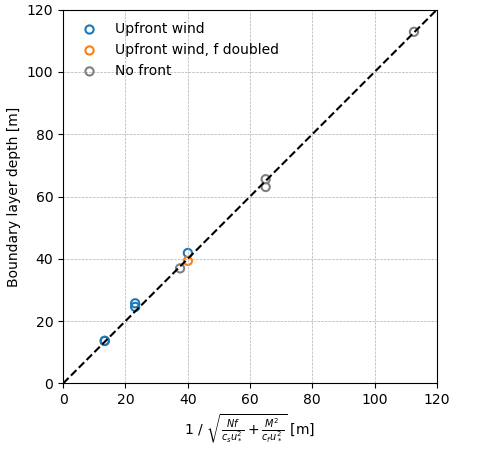

In [41]:
plt.close()
plt.figure(figsize=(5,4.5), constrained_layout=True)

plt.plot([0, 120], [0, 120], 'k', ls='--', label='_nolegend_')
plt.scatter(dsc.H[:5], dsc.bld[:5], 35, marker='o', facecolors='none', edgecolors='C0',   lw=1.5)
# plt.plot([0, 120], [0, 120*0.6], 'C0', ls='--')
# plt.text(85,60, 'Up-front wind', rotation=np.arctan(0.63)/np.pi*180, color='C0', fontsize=12)
plt.scatter(dsc.H[5], dsc.bld[5], 35, marker='o', facecolors='none', edgecolors='C1',   lw=1.5)
plt.scatter(dsc.H[6:], dsc.bld[6:], 35, marker='o', facecolors='none', edgecolors='gray', lw=1.5)
# plt.text(40,80, 'No Front', rotation=np.arctan(1.63)/np.pi*180, color='gray', fontsize=12)
plt.legend(['Upfront wind', 'Upfront wind, f doubled', 'No front'], frameon=False)
plt.gca().set_aspect('equal', 'box')
plt.grid('on', ls='--', lw=0.5)
plt.xlim(0,120)
plt.ylim(0,120)
plt.xlabel(r'1 / $\sqrt{\frac{Nf}{c_s u_*^2} + \frac{M^2}{c_fu_*^2}}$ [m]')
plt.ylabel('Boundary layer depth [m]');

# plt.savefig('../Figures/upfront_wind_bld_scaling', dpi=250);

### Budgets for frontal zone simulations

In [4]:
cname = 's11_M009_Q135_W148_D090_St0'

dsh = xr.open_dataset(data_dir+cname+'_averages.nc')
dsh['timeTf'] = dsh.time/np.timedelta64(int(np.around(2*np.pi/dsh.f)), 's')

# dsh = xr.open_dataset(data_dir+cname+'_KE_budgets.nc')
# dsh['sigmaC'] = dsh.zC / dsh.htau

dsh.close()
dsh

<xarray.Dataset> Size: 103MB
Dimensions:  (zC: 256, zF: 257, xC: 512, yF: 128, xF: 512, yC: 128, time: 1571)
Coordinates:
  * zC       (zC) float64 2kB -125.8 -125.3 -124.8 ... -1.23 -0.7383 -0.2461
  * zF       (zF) float64 2kB -126.0 -125.5 -125.0 ... -0.9844 -0.4922 0.0
  * xC       (xC) float64 4kB -499.0 -497.1 -495.1 -493.2 ... 495.1 497.1 499.0
  * yF       (yF) float64 1kB 0.0 1.953 3.906 5.859 ... 242.2 244.1 246.1 248.0
  * xF       (xF) float64 4kB -500.0 -498.0 -496.1 -494.1 ... 494.1 496.1 498.0
  * yC       (yC) float64 1kB 0.9766 2.93 4.883 6.836 ... 245.1 247.1 249.0
  * time     (time) timedelta64[ns] 13kB 00:00:00 00:02:00 ... 2 days 04:20:00
Data variables: (12/42)
    vvsgs    (time, zC) float64 3MB ...
    TKE_eps  (time, zC) float64 3MB ...
    MKE_tur  (time, zC) float64 3MB ...
    CKE_tur  (time, zC) float64 3MB ...
    b        (time, zC) float64 3MB ...
    wut      (time, zC) float64 3MB ...
    ...       ...
    dusdz    (zC) float64 2kB ...
    Vbak     (zC) float64 2kB ...
    us       (zC) float64 2kB ...
    Bbak     (xC) float64 4kB ...
    vs       (zC) float64 2kB ...
    timeTf   (time) float64 13kB 0.0 0.00191 0.00382 ... 2.995 2.997 2.998
Attributes: (12/76)
    save_checkpoint:          0
    Ly:                       250.0
    Tf:                       62831.85307179586
    use_Stokes:               0
    ∂v∂z_cgeo:                0
    time_averaging_stride:    1
    ...                       ...
    counter_geo_stress:       0
    Ny:                       128
    Oceananigans:             This file was generated using Oceananigans v0.9...
    start_from_restratified:  0
    RiB₁:                     19.753086419753085
    σ_wind:                   0

In [5]:
periodic_coords = {dim : dict(left=f'{dim}F', center=f'{dim}C') for dim in 'z'}
bounded_coords = {dim : dict(outer=f'{dim}F', center=f'{dim}C') for dim in 'z'}
coords = {dim : periodic_coords[dim] if tpl=='P' else bounded_coords[dim] for dim, tpl in zip('z', 'N')}
grid = Grid(dsh, coords=coords, periodic=['x', 'y'])
dzF = dsh.zF.diff('zF').data

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    wut_f = grid.interp(dsh.wut, axis='z', boundary='fill', fill_value=0) ## ?
    wvt_f = grid.interp(dsh.wvt, axis='z', boundary='fill', fill_value=0) ## ?
    wbt_f = grid.interp(dsh.wbt, axis='z', boundary='fill', fill_value=0)
    # wbsgs_f = grid.interp(dsh.wbsgs, axis='z', boundary='fill', fill_value=0)
    b_f   = grid.interp(dsh.b, axis='z', boundary='extend')
    dsh['Nsq'] = grid.diff(b_f, axis='z') / dzF
    dsh['dwutdz'] = grid.diff(wut_f, axis='z') / dzF
    dsh['dwvtdz'] = grid.diff(wvt_f, axis='z') / dzF
    dsh['dwbtdz'] = grid.diff(wbt_f, axis='z') / dzF
    dsh['dwbsgsdz'] = grid.diff(dsh.wbsgs, axis='z') / dzF

AttributeError: 'Dataset' object has no attribute 'heps'

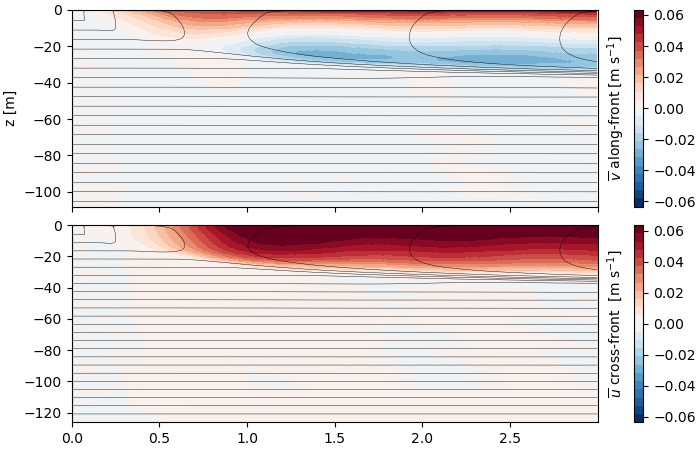

In [6]:
plt.close()
plt.figure(figsize=(7,4.5), constrained_layout=True)
bkw = dict(colors='k', linewidths=0.3)
lim1 = np.maximum(np.abs(dsh.v.quantile(0.03)), np.abs(dsh.v.quantile(0.97)))
lim2 = np.maximum(np.abs(dsh.u.quantile(0.03)), np.abs(dsh.u.quantile(0.97)))
vlim = np.maximum(lim1, lim2)
kw = dict(cmap=plt.get_cmap('RdBu_r', 24), vmin=-vlim, vmax=vlim)

plt.subplot(211)
plt.pcolormesh(dsh.timeTf, dsh.zC, dsh.v.T, **kw)
cb = plt.colorbar(pad=0.015)
cb.set_label(r'$\overline{v}$ along-front [m s$^{-1}$]', labelpad=-65)
plt.contour(dsh.timeTf, dsh.zC, dsh.b.T, np.linspace(0,dsh.b.max(),25), **bkw)
plt.gca().set_xticklabels([])
plt.ylabel('z [m]')
plt.ylim(-108,0)
plt.xlim(0,3)

plt.subplot(212)
plt.pcolormesh(dsh.timeTf, dsh.zC, dsh.u.T, **kw)
cb = plt.colorbar(pad=0.015)
cb.set_label(r'$\overline{u}$ cross-front  [m s$^{-1}$]', labelpad=-65)
plt.contour(dsh.timeTf, dsh.zC, dsh.b.T, np.linspace(0,dsh.b.max(),25), **bkw)
plt.plot(dsh.timeTf, -dsh.heps, 'm')
plt.plot(dsh.timeTf, -dsh.htau, 'c')
plt.ylabel('z [m]')
plt.xlabel(r'$T_{inertial}$');
plt.ylim(-108,0);
plt.xlim(0,3);

# plt.savefig('../Figures/'+cname+'_ubar_vbar', dpi=250)

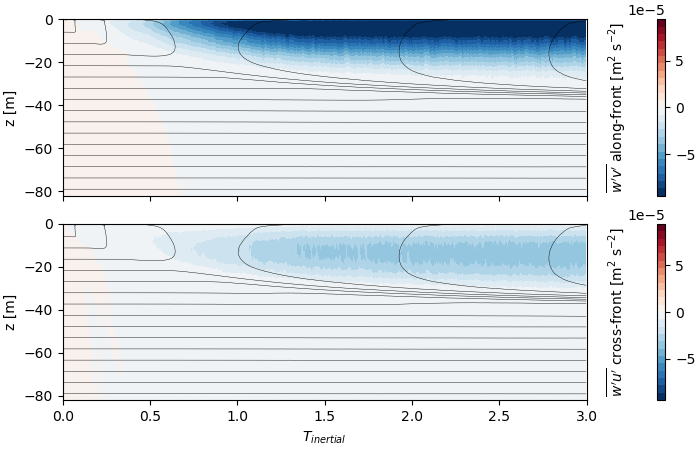

In [11]:
plt.close()
plt.figure(figsize=(7,4.5), constrained_layout=True)
bkw = dict(colors='k', linewidths=0.3)
lim1 = np.maximum(np.abs(dsh.wvt.quantile(0.03)), np.abs(dsh.wvt.quantile(0.97)))
lim2 = np.maximum(np.abs(dsh.wut.quantile(0.03)), np.abs(dsh.wut.quantile(0.97)))
vlim = np.maximum(lim1, lim2)
kw = dict(cmap=plt.get_cmap('RdBu_r', 24), vmin=-vlim, vmax=vlim)

plt.subplot(211)
plt.pcolormesh(dsh.timeTf, dsh.zC, dsh.wvt.T, **kw)
cb = plt.colorbar(pad=0.015)
cb.set_label(r"$\overline{w'v'}$ along-front [m$^2$ s$^{-2}$]", labelpad=-65)
cb.formatter.set_powerlimits((0, 0))
plt.contour(dsh.timeTf, dsh.zC, dsh.b.T, np.linspace(0,dsh.b.max(),25), **bkw)
# plt.plot(dsh.timeTf, -dsh.heps, 'm')
# plt.plot(dsh.timeTf, -dsh.htau, 'c')
plt.gca().set_xticklabels([])
plt.ylabel('z [m]')
plt.ylim(-82,0)
plt.xlim(0,3)

plt.subplot(212)
plt.pcolormesh(dsh.timeTf, dsh.zC, dsh.wut.T, **kw)
cb = plt.colorbar(pad=0.015)
cb.set_label(r"$\overline{w'u'}$ cross-front [m$^2$ s$^{-2}$]", labelpad=-65)
cb.formatter.set_powerlimits((0, 0))
plt.contour(dsh.timeTf, dsh.zC, dsh.b.T, np.linspace(0,dsh.b.max(),25), **bkw)
# plt.plot(dsh.timeTf, -dsh.heps, 'm')
# plt.plot(dsh.timeTf, -dsh.htau, 'c')
plt.ylabel('z [m]')
plt.xlabel(r'$T_{inertial}$');
plt.ylim(-82,0);
plt.xlim(0,3);

# plt.savefig('../Figures/'+cname+'_Reynolds_stress', dpi=250)

In [ ]:
plt.close()
plt.figure(figsize=(6.5,3), constrained_layout=True)
bkw = dict(colors='k', linewidths=0.3)
var = 'Rib'
vlim = np.maximum(np.abs(dsh[var].quantile(0.02)), np.abs(dsh[var].quantile(0.98)))
kw = dict(cmap=plt.get_cmap('RdBu_r', 20), vmin=0, vmax=1)#, vmin=-vlim, vmax=vlim)
_, zvar = sorted(dsh[var].dims)

plt.pcolormesh(dsh.timeTf, dsh[zvar], dsh[var].T, **kw)
cbar = plt.colorbar(pad=-0.01)
# cbar.formatter.set_powerlimits((0, 0))

plt.contour(dsh.timeTf, dsh.zC, dsh.b.T, np.linspace(0,dsh.b.max(),20), **bkw)
plt.contour(dsh.timeTf, dsh[zvar], dsh[var].T, [0.3], colors='xkcd:bright cyan', linewidths=2)
# plt.plot(dsh.timeTf, -dsh.bld, '--r')
plt.ylabel('z [m]')
plt.xlabel(r'$T_{inertial}$');
# plt.ylim(-92,0);
# plt.xlim(0,4);

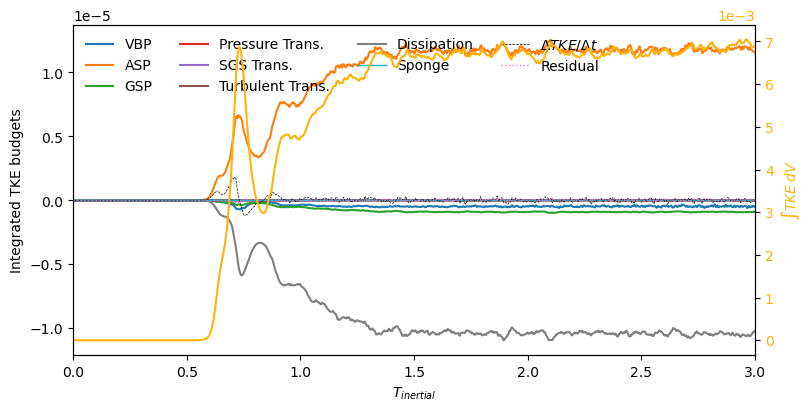

In [16]:
plt.close()
plt.figure(figsize=(8,4), constrained_layout=True)

deltaz = np.diff(dsh.zF)
itop = None
dsh['ITKE'] = (dsh.TKE*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_VBP'] = (dsh.wbt*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_ASP'] = (dsh.ASP*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_GSP'] = (dsh.GSP*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_prs'] = (dsh.TKE_prs*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_vis'] = (dsh.TKE_vis*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_tur'] = (dsh.TKE_tur*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_eps'] = (dsh.TKE_eps*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_spg'] = (dsh.TKE_spg*deltaz).isel(zC=slice(None,itop)).sum('zC')

dsh['dITKE_dt'] = dsh.ITKE.differentiate('time', datetime_unit='s') # not accurate
dsh['ITKE_res'] = dsh.dITKE_dt - (dsh.ITKE_VBP + dsh.ITKE_ASP + dsh.ITKE_GSP -
                                  dsh.ITKE_prs - dsh.ITKE_vis - dsh.ITKE_tur -
                                  dsh.ITKE_eps + dsh.ITKE_spg)

plt.plot(dsh.timeTf,  dsh.ITKE_VBP);
plt.plot(dsh.timeTf,  dsh.ITKE_ASP);
plt.plot(dsh.timeTf,  dsh.ITKE_GSP);
plt.plot(dsh.timeTf, -dsh.ITKE_prs);
plt.plot(dsh.timeTf, -dsh.ITKE_vis);
plt.plot(dsh.timeTf, -dsh.ITKE_tur);
plt.plot(dsh.timeTf, -dsh.ITKE_eps, 'gray')
plt.plot(dsh.timeTf,  dsh.ITKE_spg, 'xkcd:turquoise blue', lw=1)
plt.plot(dsh.timeTf,  dsh.dITKE_dt, '--k', lw=0.5)
plt.plot(dsh.timeTf,  dsh.ITKE_res, ':', lw=1)
plt.legend(['VBP', 'ASP', 'GSP', 'Pressure Trans.', 'SGS Trans.', 'Turbulent Trans.',
            'Dissipation', 'Sponge', r'$\Delta TKE/\Delta t$', 'Residual'],
           frameon=False, ncol=4, loc='upper left')
plt.xlabel(r'$T_{inertial}$')
plt.ylabel('Integrated TKE budgets')
# plt.ylim(-6e-7, 6e-7)
# plt.ylim(-1.6e-5, 1.9e-5)
# plt.ylim(-7e-5, 14e-5)
plt.ticklabel_format(axis='y', scilimits=(0,0))
plt.xlim(0,3)

ax1 = plt.gca().twinx()
color = 'xkcd:amber'
ax1.set_ylabel(r'$\int TKE \: dV$', color=color)
ax1.plot(dsh.timeTf, dsh.ITKE, color=color)
# ax1.set_yticks(np.arange(0,7,2)*1e-3)
# ax1.set_yticks(np.arange(0,5,1)*1e-2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.ticklabel_format(axis='y', scilimits=(0,0))
# ax1.set_ylim(-6e-3, 6e-3);
# ax1.set_ylim(-16e-3, 19e-3);
# ax1.set_ylim(-2e-2, 4e-2);

# plt.savefig('../Figures/'+cname+'_iTKE_budgets', dpi=250)

In [ ]:
dsh.ITKE_ASP.where(time_interval).mean('time')/(dsh.ustar2.where(time_interval).mean('time'))**(3/2)

In [191]:
time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)

dsh.ITKE_GSP.where(time_interval).mean('time') / dsh.ITKE_ASP.where(time_interval).mean('time')

<xarray.DataArray ()> Size: 8B
array(-0.13499123)

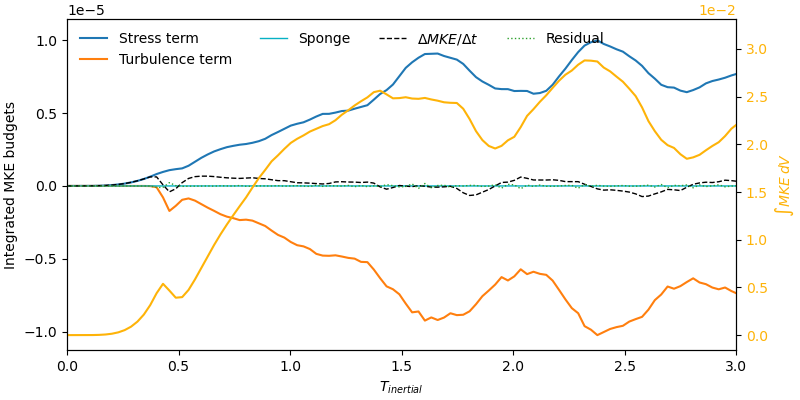

In [13]:
plt.close()
plt.figure(figsize=(8,4), constrained_layout=True)

itop = None
dsh['IMKE'] = (dsh.MKE*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['IMKE_sgs'] = (dsh.MKE_sgs*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['IMKE_stress_top'] = (dsh.MKE_stress_top*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['IMKE_tur'] = (dsh.MKE_tur*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['IMKE_stress'] = (dsh.MKE_stress*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['IMKE_spg'] = (dsh.MKE_spg*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['IMKE_eps'] = (dsh.MKE_eps*deltaz).isel(zC=slice(None,itop)).sum('zC')

dsh['dIMKE_dt'] = dsh.IMKE.differentiate('time', datetime_unit='s')
dsh['IMKE_res'] = dsh.dIMKE_dt - (- dsh.IMKE_stress - dsh.IMKE_tur + dsh.IMKE_spg)

plt.plot(dsh.timeTf, -dsh.IMKE_stress);
plt.plot(dsh.timeTf, -dsh.IMKE_tur);
# plt.plot(dsh.timeTf, -dsh.IMKE_eps, 'gray');
plt.plot(dsh.timeTf,  dsh.IMKE_spg, 'xkcd:turquoise blue', lw=1);
plt.plot(dsh.timeTf,  dsh.dIMKE_dt, '--k', lw=1)
plt.plot(dsh.timeTf,  dsh.IMKE_res, ':', lw=1)
plt.legend(['Stress term', 'Turbulence term', 'Sponge',
            r'$\Delta MKE/\Delta t$', 'Residual'],
           frameon=False, ncol=4, loc='upper left')
plt.xlabel(r'$T_{inertial}$')
plt.ylabel('Integrated MKE budgets')
# plt.ylim(-2e-7, 3e-7)
# plt.ylim(-1.4e-5, 1.8e-5)
plt.ticklabel_format(axis='y', scilimits=(0,0))
plt.xlim(0,3)

ax1 = plt.gca().twinx()
color = 'xkcd:amber'
ax1.set_ylabel(r'$\int MKE \: dV$', color=color)
ax1.plot(dsh.timeTf, dsh.IMKE, color=color)
# ax1.set_yticks(np.arange(0,13,3)*1e-4)
# ax1.set_yticks(np.arange(0,9,2)*1e-2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.ticklabel_format(axis='y', scilimits=(0,0))
# ax1.set_ylim(-0.8e-3, 1.2e-3);
# ax1.set_ylim(-7e-2, 9e-2);

# plt.savefig('../Figures/'+cname+'_iMKE_budgets', dpi=250)

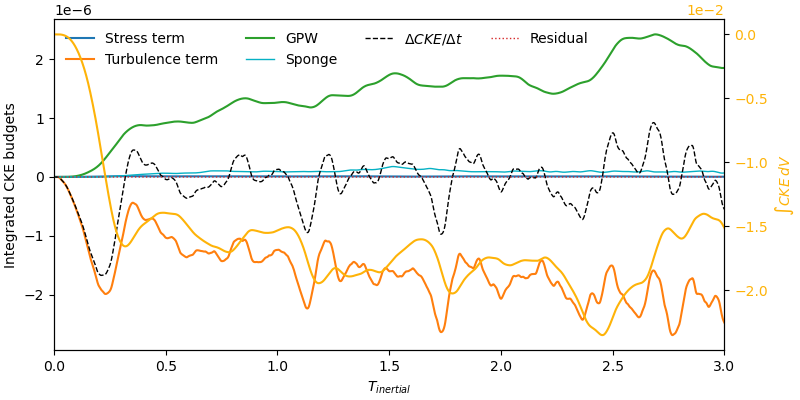

In [13]:
plt.close()
plt.figure(figsize=(8,4), constrained_layout=True)
time_interval = (dsh.timeTf >= 6) & (dsh.timeTf < 12)

itop = None
dsh['ICKE'] = (dsh.CKE*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ICKE_sgs'] = (dsh.CKE_sgs*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ICKE_stress_top'] = (dsh.CKE_stress_top*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ICKE_tur'] = (dsh.CKE_tur*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ICKE_stress'] = (dsh.CKE_stress*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ICKE_GPW'] = (dsh.CKE_GPW*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ICKE_spg'] = (dsh.CKE_spg*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ICKE_eps'] = (dsh.CKE_eps*deltaz).isel(zC=slice(None,itop)).sum('zC')

dsh['dICKE_dt'] = dsh.ICKE.differentiate('time', datetime_unit='s')
dsh['ICKE_res'] = dsh.dICKE_dt - (dsh.ICKE_GPW - dsh.ICKE_stress - dsh.ICKE_tur + dsh.ICKE_spg)

plt.plot(dsh.timeTf, -dsh.ICKE_stress);
plt.plot(dsh.timeTf, -dsh.ICKE_tur);
plt.plot(dsh.timeTf,  dsh.ICKE_GPW);
# plt.plot(dsh.timeTf, -dsh.ICKE_eps, 'gray')
plt.plot(dsh.timeTf,  dsh.ICKE_spg, 'xkcd:turquoise blue', lw=1)
plt.plot(dsh.timeTf,  dsh.dICKE_dt, '--k', lw=1)
plt.plot(dsh.timeTf,  dsh.ICKE_res, ':', lw=1)
plt.legend(['Stress term', 'Turbulence term', 'GPW', 'Sponge',
            r'$\Delta CKE/\Delta t$', 'Residual'],
           frameon=False, ncol=4, loc='upper left')
plt.xlabel(r'$T_{inertial}$')
plt.ylabel('Integrated CKE budgets')
# plt.ylim(-7e-7, 8e-7)
# plt.ylim(-9e-6, 9e-6)
# plt.ylim(-8e-5, 9e-5)
plt.ticklabel_format(axis='y', scilimits=(0,0))
plt.xlim(0,3)

ax1 = plt.gca().twinx()
color = 'xkcd:amber'
ax1.set_ylabel(r'$\int CKE \: dV$', color=color)
ax1.plot(dsh.timeTf, dsh.ICKE, color=color)
# ax1.set_yticks(np.arange(0,10,2)*1e-3)
# ax1.set_yticks(np.arange(-3,1)*1e-2)
# ax1.set_yticks(np.arange(-2,1)*1e-1)
ax1.tick_params(axis='y', labelcolor=color)
ax1.ticklabel_format(axis='y', scilimits=(0,0));
# ax1.set_ylim(-3e-2, 3e-2);
# ax1.set_ylim(-2.4e-1, 2.7e-1);

# plt.savefig('../Figures/'+cname+'_iCKE_budgets', dpi=250)

In [22]:
time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)

dsh.ICKE_tur.where(time_interval).mean('time') / dsh.ICKE_stress.where(time_interval).mean('time')

<xarray.DataArray ()> Size: 8B
array(-0.45786878)

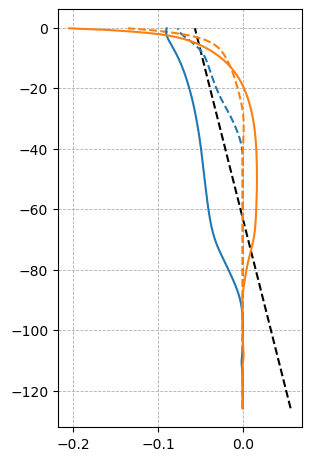

In [37]:
plt.close()
plt.figure(figsize=(3,4.5), constrained_layout=True)

time_interval = (dsh.timeTf >= 0) & (dsh.timeTf < 1)
plt.plot(dsh.Vbak, dsh.zC, '--k')
plt.plot(dsh.u.where(time_interval).mean('time'), dsh.zC, '--')
plt.plot(dsh.v.where(time_interval).mean('time'), dsh.zC, '--');
plt.gca().set_prop_cycle(None)
time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)
plt.plot(dsh.u.where(time_interval).mean('time'), dsh.zC)
plt.plot(dsh.v.where(time_interval).mean('time'), dsh.zC);
plt.grid('on', ls='--', lw=0.6)
# plt.ylim(-72,0);

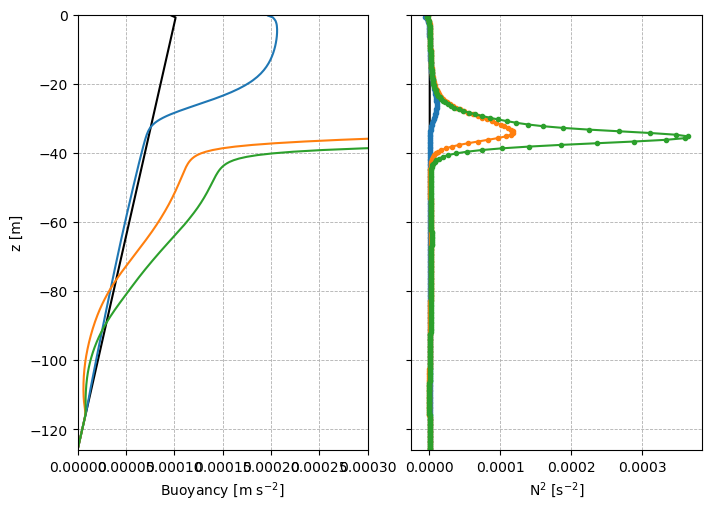

In [12]:
plt.close()
_,ax = plt.subplots(1,2, figsize=(7,5), constrained_layout=True, sharey=True)

time_interval = (dsh.timeTf >= 0) & (dsh.timeTf < 1)
ax[0].plot(dsh.b.isel(time=0), dsh.zC, 'k')
ax[0].plot(dsh.b.where(time_interval).mean('time'), dsh.zC)
ax[1].plot(dsh.dbdz.isel(time=0), dsh.zC, 'k')
ax[1].plot(dsh.dbdz.where(time_interval).mean('time'), dsh.zC, '.-')

time_interval = (dsh.timeTf >= 1) & (dsh.timeTf < 2)
ax[0].plot(dsh.b.where(time_interval).mean('time'), dsh.zC)
ax[1].plot(dsh.dbdz.where(time_interval).mean('time'), dsh.zC, '.-')

time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)
ax[0].plot(dsh.b.where(time_interval).mean('time'), dsh.zC)
ax[1].plot(dsh.dbdz.where(time_interval).mean('time'), dsh.zC, '.-')

ax[0].grid('on', ls='--', lw=0.6)
ax[1].grid('on', ls='--', lw=0.6)
ax[0].set_xlim(0, 3e-4)
ax[0].set_ylim(-126, 0)
ax[0].set_ylabel('z [m]');
ax[0].set_xlabel(r'Buoyancy [m s$^{-2}$]')
ax[1].set_xlabel(r'N$^2$ [s$^{-2}$]');

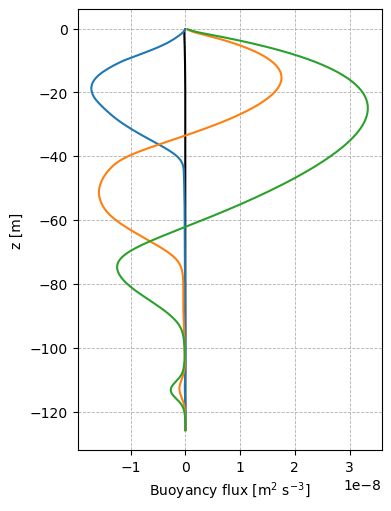

In [40]:
plt.close()
plt.figure(figsize=(3.8,5), constrained_layout=True)

time_interval = (dsh.timeTf >= 0) & (dsh.timeTf < 1)
plt.plot(dsh.wbt.isel(time=0), dsh.zC, 'k')
plt.plot(dsh.wbt.where(time_interval).mean('time'), dsh.zC)
time_interval = (dsh.timeTf >= 1) & (dsh.timeTf < 2)
plt.plot(dsh.wbt.where(time_interval).mean('time'), dsh.zC)
time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)
plt.plot(dsh.wbt.where(time_interval).mean('time'), dsh.zC)

plt.grid('on', ls='--', lw=0.6)
# plt.xlim(-1e-8, 4e-8)
# plt.ylim(-72, 0)
plt.ylabel('z [m]');
plt.xlabel(r'Buoyancy flux [m$^2$ s$^{-3}$]');

In [ ]:
plt.close()
plt.figure(figsize=(8,5), constrained_layout=True)
time_interval = (dsh.timeTf >= 0.5) & (dsh.timeTf < 3)
idepth = dsh.wbt.where(time_interval, drop=True).argmin('zC')

plt.scatter(dsh.ASP.where(time_interval, drop=True).isel(zC=idepth)/10, -dsh.wbt.where(time_interval, drop=True).min('zC'),
            10, c=dsh.timeTf.where(time_interval, drop=True), cmap='rainbow')
plt.gca().set_aspect('equal', 'box');
plt.xlim(0, 1.4e-7)
plt.ylim(0, 1.4e-7);

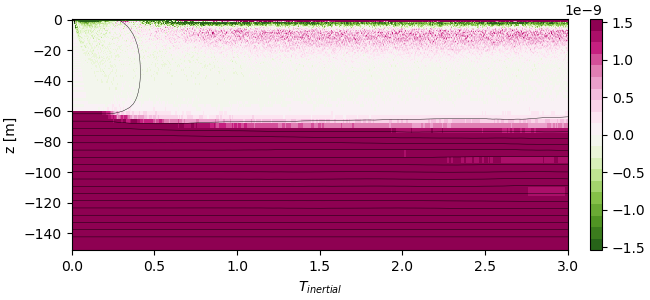

In [26]:
plt.close()
plt.figure(figsize=(6.5,3), constrained_layout=True)
bkw = dict(colors='k', linewidths=0.3)
var = 'q'
vlim = np.maximum(np.abs(dsh[var].quantile(0.1)), np.abs(dsh[var].quantile(0.9)))
kw = dict(cmap=plt.get_cmap('PiYG_r', 20), vmin=-vlim, vmax=vlim)
_, zvar = sorted(dsh[var].dims)

plt.pcolormesh(dsh.timeTf, dsh[zvar], dsh[var].T, **kw)
cbar = plt.colorbar(pad=-0.03)
cbar.formatter.set_powerlimits((0, 0))

plt.contour(dsh.timeTf, dsh.zC, dsh.b.T, np.linspace(0,dsh.b.max(),20), **bkw)
# plt.contour(dsh.timeTf, dsh[zvar], dsh[var].T, [0], colors='C0', linewidths=0.5)
plt.ylabel('z [m]')
plt.xlabel(r'$T_{inertial}$');
# plt.ylim(-84,0);
# plt.xlim(0,4);

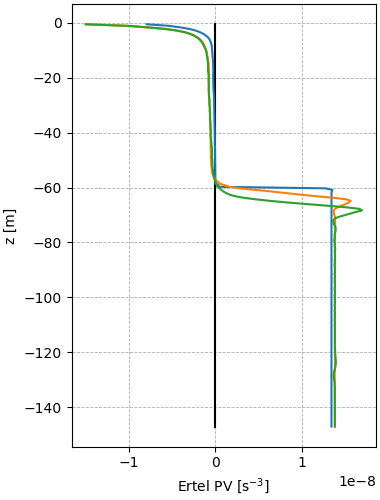

In [14]:
plt.close()
plt.figure(figsize=(3.8,5), constrained_layout=True)

plt.plot(dsh.q.isel(time=0)[:-1], dsh.zF[:-1], 'k')

# time_interval = (dsh.timeTf >= 0) & (dsh.timeTf < 0.5)
# plt.plot(dsh.q.where(time_interval).mean('time')[:-1], dsh.zF[:-1])
# time_interval = (dsh.timeTf >= 0.5) & (dsh.timeTf < 1)
# plt.plot(dsh.q.where(time_interval).mean('time')[:-1], dsh.zF[:-1])
# time_interval = (dsh.timeTf >= 1) & (dsh.timeTf < 1.5)
# plt.plot(dsh.q.where(time_interval).mean('time')[:-1], dsh.zF[:-1])
# time_interval = (dsh.timeTf >= 1.5) & (dsh.timeTf < 2)
# plt.plot(dsh.q.where(time_interval).mean('time')[:-1], dsh.zF[:-1])


time_interval = (dsh.timeTf >= 0) & (dsh.timeTf < 1)
plt.plot(dsh.q.where(time_interval).mean('time')[:-1], dsh.zF[:-1])
time_interval = (dsh.timeTf >= 1) & (dsh.timeTf < 2)
plt.plot(dsh.q.where(time_interval).mean('time')[:-1], dsh.zF[:-1])
time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)
plt.plot(dsh.q.where(time_interval).mean('time')[:-1], dsh.zF[:-1])

plt.grid('on', ls='--', lw=0.6)
# plt.xlim(-1e-8, 4e-8)
# plt.ylim(-72, 0)
plt.ylabel('z [m]');
plt.xlabel(r'Ertel PV [s$^{-3}$]');

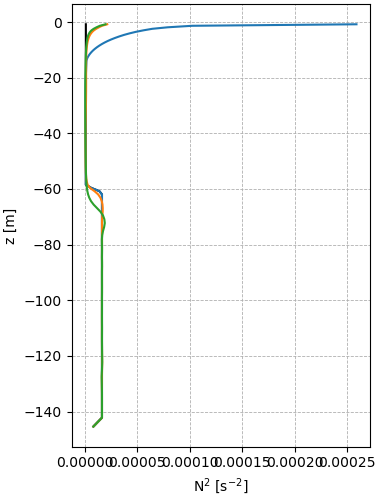

In [20]:
plt.close()
plt.figure(figsize=(3.8,5), constrained_layout=True)

time_interval = (dsh.timeTf >= 0) & (dsh.timeTf < 1)
plt.plot(dsh.Nsq.isel(time=0)[:-1], dsh.zC[:-1], 'k')
plt.plot(dsh.Nsq.where(time_interval).mean('time')[:-1], dsh.zC[:-1])
time_interval = (dsh.timeTf >= 1) & (dsh.timeTf < 2)
plt.plot(dsh.Nsq.where(time_interval).mean('time')[:-1], dsh.zC[:-1])
time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)
plt.plot(dsh.Nsq.where(time_interval).mean('time')[:-1], dsh.zC[:-1])

plt.grid('on', ls='--', lw=0.6)
# plt.xlim(-1e-8, 4e-8)
# plt.ylim(-72, 0)
plt.ylabel('z [m]');
plt.xlabel(r'N$^2$ [s$^{-2}$]');

#### Reynolds stress

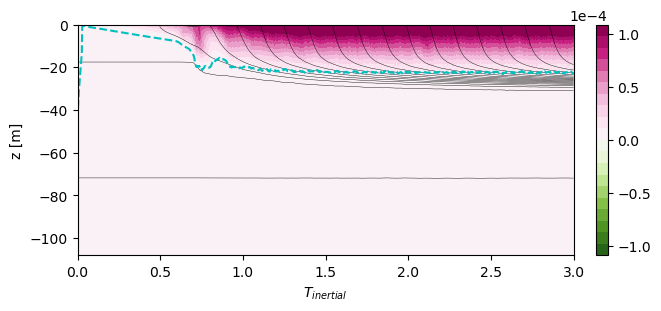

In [17]:
plt.close()
plt.figure(figsize=(6.5,3), constrained_layout=True)
bkw = dict(colors='k', linewidths=0.3)
var = 'wuv'
vlim = np.maximum(np.abs(dsh[var].quantile(0.02)), np.abs(dsh[var].quantile(0.98)))
kw = dict(cmap=plt.get_cmap('PiYG_r', 20), vmin=-vlim, vmax=vlim)
_, zvar = sorted(dsh[var].dims)

plt.pcolormesh(dsh.timeTf, dsh[zvar], dsh[var].T, **kw)
cbar = plt.colorbar(pad=-0.03)
cbar.formatter.set_powerlimits((0, 0))

plt.contour(dsh.timeTf, dsh.zC, dsh.b.T, np.linspace(0,dsh.b.max(),20), **bkw)
plt.plot(dsh.timeTf, -dsh.htau, '--c')

plt.ylabel('z [m]')
plt.xlabel(r'$T_{inertial}$');
plt.ylim(-108,0);
plt.xlim(0,3);

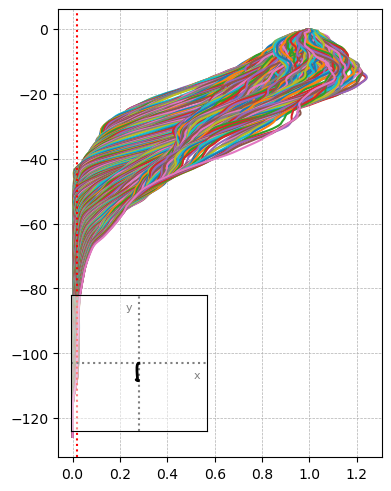

In [12]:
plt.close()
fig = plt.figure(figsize=(3.8,4.8), constrained_layout=True)
time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)
zdum = np.linspace(-1,0)

# plt.plot(dsh.wu.where(time_interval).mean(['time']),
#          dsh.zC.where(time_interval).mean(['time']));
# plt.plot(dsh.wv.where(time_interval).mean(['time']),
#          dsh.zC.where(time_interval).mean(['time']));

plt.plot(dsh.wuvn.where(time_interval).T, dsh.zC)
plt.axvline(0.02, c='r', ls=':')

axins = plt.gca().inset_axes([0.04, 0, 0.42, 0.42],
                             xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axins.axvline(0, ls=':', c='gray')
axins.axhline(0, ls=':', c='gray')
axins.plot(-dsh.wu.where(time_interval).mean(['time']), 
           -dsh.wv.where(time_interval).mean(['time']), 'k', lw=2)
axins.text(0.95, 0.45, 'x', ha='right', va='top', color='gray', transform=axins.transAxes, fontsize=8)
axins.text(0.45, 0.95, 'y', ha='right', va='top', color='gray', transform=axins.transAxes, fontsize=8)
axins.set_aspect('equal', 'box')
axins.patch.set_alpha(0.5)
# axins.set_xlim(-4e-5,4e-5)
# axins.set_ylim(-4e-5,4e-5);
axins.set_xlim(-1.4e-4,1.4e-4)
axins.set_ylim(-1.4e-4,1.4e-4);

# plt.plot((np.sqrt(dsh.wv**2 + dsh.wu**2)/dsh.ustar2).where(time_interval).mean(['time']),
#          dsh.zohC.where(time_interval).mean(['time']), '.');
# plt.plot(np.abs( (1 + zdum)**(3/2 - np.sqrt(3)/2*1j) ), zdum)
plt.grid('on', ls='--', lw=0.5)
# plt.ylim(-1.2, 0);
# plt.xlim(-1,1);

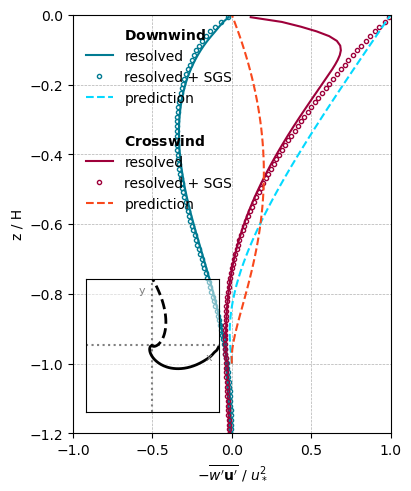

In [33]:
plt.close()
fig = plt.figure(figsize=(4,4.8), constrained_layout=True)
time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)
zdum = np.linspace(-1,0)
tau_Derbyshire = -(1+zdum)**(3/2 - np.sqrt(3)/2*1j)

p1, = plt.plot(-(dsh.wvt/dsh.ustar2).where(time_interval).mean(['time']), dsh.sigmaC.where(time_interval).mean(['time']), c='xkcd:ocean')
p2, = plt.plot(-(dsh.wut/dsh.ustar2).where(time_interval).mean(['time']), dsh.sigmaC.where(time_interval).mean(['time']), c='xkcd:cranberry')
p3, = plt.plot(-(dsh.wv/dsh.ustar2).where(time_interval).mean(['time']), dsh.sigmaC.where(time_interval).mean(['time']),
         'o', c='xkcd:ocean', markersize=3, mfc='none', lw=0.02)
p4, = plt.plot(-(dsh.wu/dsh.ustar2).where(time_interval).mean(['time']), dsh.sigmaC.where(time_interval).mean(['time']),
         'o', c='xkcd:cranberry',   markersize=3, mfc='none', lw=0.02)
p5, = plt.plot(-np.real(tau_Derbyshire), zdum, '--', c='xkcd:neon blue')
p6, = plt.plot(-np.imag(tau_Derbyshire), zdum, '--', c='xkcd:reddish orange')
p7, = plt.plot([0], marker='None', linestyle='None')
p8  = matplotlib.patches.Rectangle((0,0), 0, 0, color='w')
plt.legend([p8, p1, p3, p5, p7, p8, p2, p4, p6],
           [r'$\bf{Downwind}$',  'resolved', 'resolved + SGS', 'prediction', '',
            r'$\bf{Crosswind}$', 'resolved', 'resolved + SGS', 'prediction'], frameon=False)
plt.grid('on', ls='--', lw=0.5)
plt.ylim(-1.2, 0)
plt.xlim(-1,1)
plt.ylabel('z / H');
plt.xlabel(r"$-\overline{w'\bf{u}'}$ / $u_*^2$");

axins = plt.gca().inset_axes([0.04, 0, 0.42, 0.42],
                             xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axins.axvline(0, ls=':', c='gray')
axins.axhline(0, ls=':', c='gray')
axins.plot(-(dsh.wu/dsh.ustar2).where(time_interval).mean(['time']), 
           -(dsh.wv/dsh.ustar2).where(time_interval).mean(['time']), 'k', lw=2)
axins.plot(-np.imag(tau_Derbyshire), -np.real(tau_Derbyshire), '--k', lw=2)
axins.text(0.95, 0.45, 'x', ha='right', va='top', color='gray', transform=axins.transAxes, fontsize=8)
axins.text(0.45, 0.95, 'y', ha='right', va='top', color='gray', transform=axins.transAxes, fontsize=8)
axins.set_aspect('equal', 'box')
axins.patch.set_alpha(0.5)
axins.set_xlim(-1,1)
axins.set_ylim(-1,1);

# plt.savefig('../Figures/'+cname+'_stress_profile', dpi=600);
# plt.savefig('../Figures/'+cname+'_stress_profile.pdf', dpi=600, format='pdf')

#### Dissipation

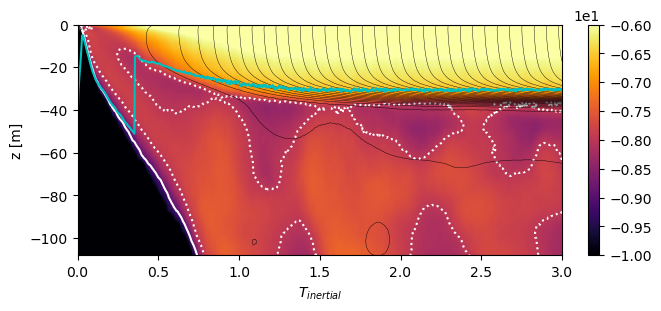

In [14]:
plt.close()
plt.figure(figsize=(6.5,3), constrained_layout=True)
bkw = dict(colors='k', linewidths=0.3)
# kw = dict(cmap='inferno', vmin=1e-8, vmax=1e-7)
kw = dict(cmap='inferno', vmin=-10, vmax=-6)

plt.pcolormesh(dsh.timeTf, dsh.zC, np.log10(dsh.TKE_eps.clip(min=1e-12)).T, **kw)
cbar = plt.colorbar(pad=-0.0)
cbar.formatter.set_powerlimits((0, 0))
plt.contour(dsh.timeTf, dsh.zC, dsh.TKE_eps.T, [1e-8], colors='w', linestyles=':')
plt.contour(dsh.timeTf, dsh.zC, dsh.TKE_eps.T, [1e-9], colors='w')
plt.contour(dsh.timeTf, dsh.zC, dsh.b.T, np.arange(0,2.6,0.01)*1e-2, **bkw)
plt.plot(dsh.timeTf, -dsh.htau, 'c')
plt.ylabel('z [m]')
plt.xlabel(r'$T_{inertial}$')
plt.ylim(-108,0)
plt.xlim(0,3);

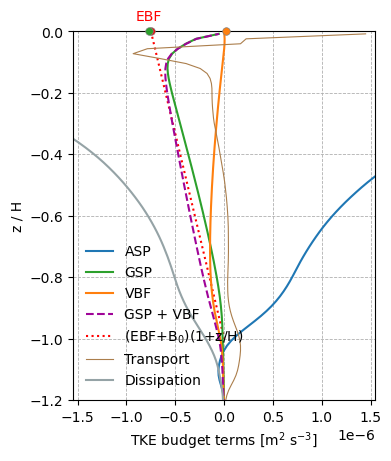

In [16]:
plt.close()
fig = plt.figure(figsize=(3.8,4.5), constrained_layout=True)
time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)

B0  = dsh.Qb.where(time_interval).mean('time')
EBF = dsh.Qv.where(time_interval).mean('time')*dsh.attrs['M²']/dsh.f
TBF = EBF + B0
l1, = plt.plot([TBF, 0], [0, -1], ':r', label='_nolegend_')
l2, = plt.plot(dsh.ASP.where(time_interval).mean(['time']), dsh.sigmaC.where(time_interval).mean('time'))
# plt.plot(dsh.SSP.where(time_interval).mean(['time']), dsh.zohC.where(time_interval).mean('time'))
l3, = plt.plot(dsh.GSP.where(time_interval).mean(['time']), dsh.sigmaC.where(time_interval).mean('time'), 'C2')
l4, = plt.plot(dsh.wbt.where(time_interval).mean(['time']), dsh.sigmaC.where(time_interval).mean('time'), 'C1')
# plt.plot(dsh.wbsgs.where(time_interval).mean(['time']), dsh.zF/dsh.bld.where(time_interval).mean('time'), '--C1',lw=0.5, label='_nolegend_')
l5, = plt.plot((dsh.GSP+dsh.wbt).where(time_interval).mean(['time']),
         dsh.sigmaC.where(time_interval).mean('time'), '--', c='xkcd:barney purple')
l6, = plt.plot(-(dsh.TKE_tur+dsh.TKE_prs+dsh.TKE_vis).where(time_interval).mean(['time']),
         dsh.sigmaC.where(time_interval).mean('time'), 'xkcd:tan brown', lw=0.8)
l7, = plt.plot(-dsh.TKE_eps.where(time_interval).mean(['time']),
         dsh.sigmaC.where(time_interval).mean('time'), 'xkcd:cool grey')
plt.scatter(TBF, 0, 30, 'r',  marker='o', edgecolor='gray', lw=0.5, clip_on=False, zorder=3)
plt.scatter(EBF, 0, 30, 'C2', marker='o', edgecolor='gray', lw=0.5, clip_on=False, zorder=3)
plt.scatter(B0,  0, 30, 'C1', marker='o', edgecolor='gray', lw=0.5, clip_on=False, zorder=3)
plt.xlim(-np.abs(EBF)*2, np.abs(EBF)*2)

if EBF > 0:
    plt.text(0.75, 1.03, 'EBF', color='r', ha='center', transform=plt.gca().transAxes)
elif EBF < 0:
    plt.text(0.25, 1.03, 'EBF', color='r', ha='center', transform=plt.gca().transAxes)
else:
    plt.text(0.5, 1.03, 'EBF', color='r', ha='center', transform=plt.gca().transAxes)

# plt.xlim(-2.4e-7,2.4e-7)
# plt.xlim(-4.5*269/1026/3991*9.81*2e-4, 4.5*269/1026/3991*9.81*2e-4)

lgd = plt.legend([l2, l3, l4, l5, l1, l6, l7],
           ['ASP', 'GSP', 'VBF', 'GSP + VBF', r'(EBF+B$_0$)(1+z/H)', 'Transport', 'Dissipation'], frameon=False, 
           loc='lower left')
plt.grid('on', ls='--', lw=0.6)
plt.ylim(-1.2, 0)
plt.ylabel('z / H');
plt.xlabel(r'TKE budget terms [m$^2$ s$^{-3}$]');

# plt.savefig('../Figures/'+cname+'_TKE_budgets', dpi=600)

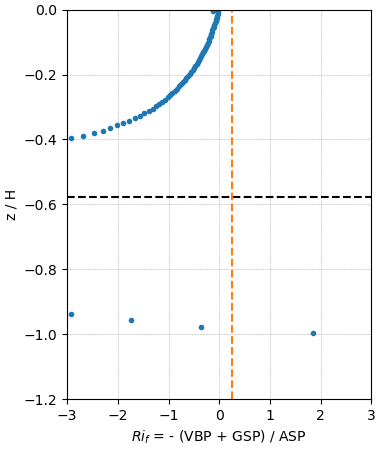

In [86]:
plt.close()
fig = plt.figure(figsize=(3.8,4.5), constrained_layout=True)
time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)

plt.plot(-EBF*(1+dsh.zC/dsh.bld.where(time_interval).mean(['time'])) / (dsh.ASP).where(time_interval).mean(['time']), dsh.zohC.where(time_interval).mean(['time']), '.')
plt.axhline(-np.sqrt(np.abs(dsh.Qv[-1]))*dsh.f/dsh.attrs['M²']/0.4/dsh.mld.where(time_interval).mean(['time']), ls='--', c='k')
# plt.axhline(-dsh.bld.where(time_interval).mean(['time']), ls='--', c='c')
plt.axvline(0.25, ls='--', c='C1')
plt.grid('on', ls='--', lw=0.4)
plt.ylim(-1.2, 0)
plt.xlim(-3, 3)
plt.ylabel('z / H')
plt.xlabel(r'$Ri_f$ = - (VBP + GSP) / ASP');

# plt.savefig('../Figures/'+cname+'_Rif', dpi=250)

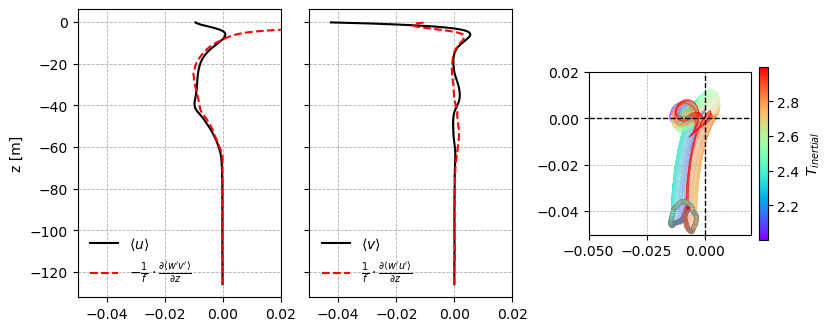

In [12]:
plt.close()
fig = plt.figure(figsize=(8.2,3.2), constrained_layout=True)
gs = gridspec.GridSpec(1, 14, figure=fig)

time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)
vmax =  np.ceil(np.max(np.stack([dsh.u, dsh.v]))*100)/100
vmin = np.floor(np.min(np.stack([dsh.u, dsh.v]))*100)/100

ax1 = fig.add_subplot(gs[0, :5])
plt.plot(dsh.u.where(time_interval).mean(['time']), dsh.zC, 'k')
plt.plot(-dsh.dwvtdz.where(time_interval).mean(['time'])/1e-4, dsh.zC, '--r')
plt.grid('on', ls='--', lw=0.6)
plt.legend([r'$\langle u \rangle$', r"$-\frac{1}{f} \cdot \frac{\partial \langle w'v' \rangle}{\partial z}$"],
           frameon=False)
# plt.ylim(-70, 0)
plt.xlim(vmin, vmax)
plt.ylabel('z [m]');

ax2 = fig.add_subplot(gs[0, 5:10])
plt.plot(dsh.v.where(time_interval).mean(['time']), dsh.zC, 'k')
plt.plot(dsh.dwutdz.where(time_interval).mean(['time'])/1e-4, dsh.zC, '--r')
plt.grid('on', ls='--', lw=0.6)
plt.legend([r'$\langle v \rangle$', r"$\frac{1}{f} \cdot \frac{\partial \langle w'u' \rangle}{\partial z}$"],
           frameon=False)
plt.gca().set_yticklabels([])
# plt.ylim(-70, 0)
plt.xlim(vmin, vmax)

ax3 = fig.add_subplot(gs[0, 10:])
tmp = dsh.where(time_interval, drop=True)
nc = tmp.sizes['time']
colors = plt.cm.rainbow(np.linspace(0,1,nc))
for i in range(0,nc,3):
    u = tmp.u.isel(time=i).sel(zC=slice(-110,0))
    v = tmp.v.isel(time=i).sel(zC=slice(-110,0))
    plt.plot(u, v, c=colors[i], lw=0.2)
sc = plt.scatter(tmp.u.sel(zC=0, method='nearest').thin(3), 
                 tmp.v.sel(zC=0, method='nearest').thin(3), 10, c=tmp.timeTf.thin(3),
                 cmap='rainbow', edgecolor='gray', lw=0.5, zorder=3)
cb = plt.colorbar(sc, shrink=0.6)
cb.set_label(r'$T_{inertial}$')
# plt.plot(dsh.u.where(time_interval).mean(['time']), dsh.v.where(time_interval).mean(['time']))
plt.axhline(0, c='k', ls='--', lw=1)
plt.axvline(0, c='k', ls='--', lw=1)
plt.gca().set_aspect('equal', 'box')
plt.grid('on', ls='--', lw=0.5);
plt.xlim(vmin, vmax);
plt.ylim(vmin, vmax);

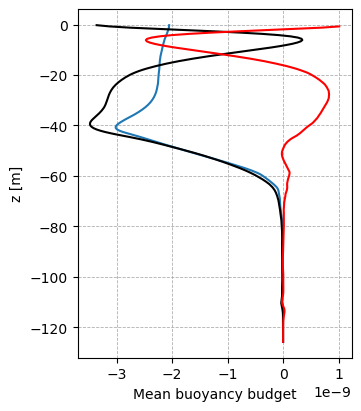

In [13]:
plt.close()
fig = plt.figure(figsize=(3.5,4), constrained_layout=True)
time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)
dshb = dsh.b.where(time_interval, drop=True).isel(time=[0,-1]).T

plt.plot(dshb.diff('time')/dshb.time.diff('time').dt.seconds, dsh.zC)
plt.plot(dsh.attrs['M²']*dsh.u.where(time_interval).mean(['time']), dsh.zC, 'k')
plt.plot(-dsh.dwbtdz.where(time_interval).mean(['time'])[:-1] - dsh.dwbsgsdz.where(time_interval).mean(['time'])[:-1], dsh.zC[:-1], 'r')
# plt.plot(-dsh.dwbsgsdz.where(time_interval).mean(['time']), dsh.zC, '--r', lw=0.5)
# plt.plot(-dsh.dwbtdz.where(time_interval).mean(['time']) -
#           dsh.dwbsgsdz.where(time_interval).mean(['time']) +
#           dsh.attrs['M²']*dsh.u.where(time_interval).mean(['time']), dsh.zC, ':b')
plt.grid('on', ls='--', lw=0.6)
# plt.legend([r'$\frac{\partial \langle b \rangle}{\partial t}$', r'$-\langle u \rangle M^2$',
#             r"$-\frac{\partial \langle w'b' \rangle}{\partial z}$"])
# plt.ylim(-90, 0)
# plt.xlim(-4e-9, 4e-9)
plt.ylabel('z [m]')
plt.xlabel('Mean buoyancy budget');

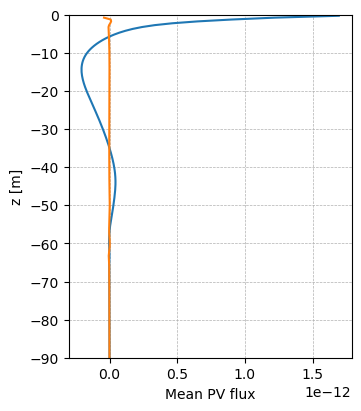

In [91]:
plt.close()
fig = plt.figure(figsize=(3.5,4), constrained_layout=True)
time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)

# plt.plot(dsh.wqt.where(time_interval).mean(['time']), dsh.zF, 'k')
plt.plot(-dsh.f*dsh.attrs['M²']*dsh.u.where(time_interval).mean(['time']), dsh.zC)
plt.plot(-dsh.f*dsh.attrs['M²']*dsh.u.where(time_interval).mean(['time'])[:-1] +
          dsh.f*dsh.dwbsgsdz.where(time_interval).mean(['time'])[:-1] +
          dsh.f*dsh.dwbtdz.where(time_interval).mean(['time'])[:-1], dsh.zC[:-1])
plt.grid('on', ls='--', lw=0.5)
plt.ylim(-90, 0)
# plt.xlim(-4e-9, 4e-9)
plt.ylabel('z [m]');
plt.xlabel('Mean PV flux');